In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random


In [2]:
import os 
os.environ['KAGGLE_USERNAME'] = "beasterea1109"
os.environ['KAGGLE_KEY'] = "a876ec11ffb6bb37bf785a0af44506cf"


**우선 나중에 keras를 이용한 convolution layer을 학습시키기 위해서 ImageDataGenerator을 이용해서 rock_paper_sissor dataset을 만들 것이다.**

In [3]:
paper_img_path = "H:\\이지혜\\rockpaperscissors\\rps-cv-images\\paper"
rock_img_path = "H:\\이지혜\\rockpaperscissors\\rps-cv-images\\rock"
scissor_img_path = "H:\\이지혜\\rockpaperscissors\\rps-cv-images\\scissors"
full_img_path = "H:\\이지혜\\rockpaperscissors\\rps-cv-images"

In [8]:
import pathlib
from skimage import io
img_dir = list(pathlib.Path(full_img_path).glob('*/*'))
img_dir = list(map(lambda x:str(x),img_dir))

In [49]:
img_dir[0]

'H:\\이지혜\\rockpaperscissors\\rps-cv-images\\paper\\04l5I8TqdzF9WDMJ.png'

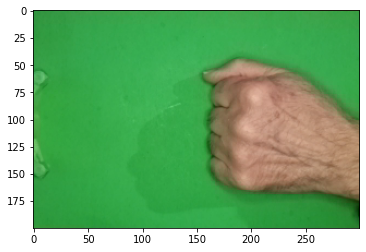

In [9]:
plt.imshow(io.imread(img_dir[1000]))

In [10]:
label_list = []
for i in range(len(img_dir)):
    temp = img_dir[i]
    if temp.split('\\')[-2] == 'rock':
        label_list.append(0)
    elif temp.split('\\')[-2] == 'paper':
        label_list.append(1)
    else:label_list.append(2)

In [11]:
label_list[:3]

[1, 1, 1]

In [56]:
from skimage.transform import resize
def read_img(path):
    image = io.imread(path)
    image = resize(image, [64,64])
    return image / 255.0

def img_process(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img)
    img = tf.image.resize(img, (64,64))
    img = tf.cast(img, tf.float64)
    return img/255.0,label

**image 데이터 처리할 때 dataset을 만들기 위해서 고려해야 할 사항**
1. tf.data.Dataset으로 바꾸고 싶으면 우선 저장 경로 등을 list나 array의 형태로 담은 데이터를 target데이터와 함께  
```tf.data.Dataset.from_tensor_slices()```를 이용해서 하나의 dataset으로 만들자.
2. 저장 경로로부터 image의 3차원 형태로 바꾸고 싶다면 ```tf.io.read_file()```로 읽고 ```tf.image.decode_종류```로 바꾸어주고 ```tf.image.resize()```를 이용해서 모두 같은 크기로 바꾸어준다.
3. 그리고 중요한 것은 이미지 데이터의 크기의 첫번째 차원은 무조건 batch_size인데 그것때문에라도 tf.data.Dataset()을 이용해 주어야 한다

In [57]:
dataset = tf.data.Dataset.from_tensor_slices((img_dir, label_list))
dataset = dataset.map(img_process)

In [60]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
dataset = dataset.repeat().shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [61]:
dataset

<PrefetchDataset shapes: ((None, 64, 64, None), (None,)), types: (tf.float64, tf.int32)>

In [31]:
len(img_data), len(label_list)

(2188, 2188)

In [32]:
from sklearn.model_selection import train_test_split
train_img, test_img, train_label, test_label = train_test_split(img_data, label_list, shuffle = True)
train_img, val_img, train_label, val_label = train_test_split(train_img, train_label, shuffle = True)

In [33]:
len(train_img), len(test_img), len(val_img)

(1230, 547, 411)

In [66]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(input_shape = [64,64,3], filters = 3, kernel_size = 3, strides = 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [67]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 22, 22, 3)         84        
_________________________________________________________________
flatten_3 (Flatten)          (None, 1452)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                92992     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 93,271
Trainable params: 93,271
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
BATCH_SIZE = 32
model.fit(dataset, steps_per_epoch = len(img_dir)//BATCH_SIZE, epochs = 5)

Train for 68 steps
Epoch 1/5
68/68 [==============================] - 10s 149ms/step - loss: 7.1313 - accuracy: 0.7528
Epoch 2/5
68/68 [==============================] - 7s 100ms/step - loss: 13.0247 - accuracy: 0.6356 6
Epoch 3/5
68/68 [==============================] - 7s 100ms/step - loss: 9.0789 - accuracy: 0.4733
Epoch 4/5
68/68 [==============================] - 7s 97ms/step - loss: 9.7796 - accuracy: 0.3920
Epoch 5/5
68/68 [==============================] - 7s 108ms/step - loss: 24.3270 - accuracy: 0.3681


In [96]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    fill_mode="nearest",
    vertical_flip=False,
    rescale=None,
    data_format=None,
    validation_split=0.2,
    dtype=tf.float32,
)

In [97]:
train_val_dataset = img_generator.flow_from_directory(
    full_img_path,
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_format="png",
    interpolation="nearest",
)

Found 2188 images belonging to 3 classes.


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(input_shape = [256, 256, 3], filters = 2, kernel_size = 2, strides = 2, padding = 'same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
model.fit(train_val_dataset, epochs = 5)


**만들어준 데이터셋으로 학습까지 된다는 사실을 파악했기 때문에 이제는 진행을 해도 좋을 것이다. 우선 padding, strides, kernel_size, filter의 역할및 차원의 정의 등에 대해 공부해 보자.**

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### 03. 현대 신경망
1. 합성곱 신경망이 computer vision에 사용되는 방법
2. Convolution Network 구현
3. 최적화 기법 구현 및 효과적인 훈련 방법
4. overfitting을 피하는 최적화 기법

#### Convolution Model의 구현 동작 공부해보기
- 직접 keras가 제공해주는 Convolution Layer, MaxPool Layer등을 filter, strides, padding값에 변화를 주어가면서 결과를 보고 어떤 식으로 적용이 되는지 살펴볼 예정이다.
- tf.keras뿐만 아니라 tf.nn.conv2d도 사용해 볼 예정이다.
- CNN이 어떤 식으로 필터를 학습시키는지 구현하고 공부해 볼 예정이다.


In [3]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
from skimage import io
single_img_path = "C:\\Users\\이지혜\\OneDrive\\사진\\제목 없음 (2).png"
img = io.imread(single_img_path)

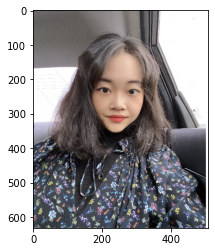

In [72]:
plt.imshow(img)
img = tf.convert_to_tensor(img, tf.float32)
#여기서 이미지 데이터의 구조가 일반적으로는 (배치 크기, 가로, 세로, 차원수)임을 고려할때 tf.expand_dims()를 해주는 과정이 필요하다.

In [73]:
img = tf.expand_dims(img, axis = 0)
print("Tensor_shape : {}".format(img.shape))

Tensor_shape : (1, 632, 509, 3)


```tf.nn.conv2d()```
1. input
    - A Tensor. Must be one of the following types: half, bfloat16, float32, float64. A Tensor of rank at least 4.
    - The dimension order is interpreted according to the value of data_format; with the all-but-inner-3 dimensions acting as batch dimensions. See below for details.
2. filters	
     - A Tensor. Must have the same type as input.
     - A 4-D tensor of shape [filter_height, filter_width, in_channels, out_channels]
3. strides	
    - An int or list of ints that has length 1, 2 or 4. 
    - The stride of the sliding window for each dimension of input. If a single value is given it is replicated in the H and W dimension. By default the N and C dimensions are set to 1. The dimension order is determined by the value of data_format, see below for details.
4. padding	
    - Either the string "SAME" or "VALID" indicating the type of padding algorithm to use, or a list indicating the explicit paddings at the start and end of each dimension. 
    - When explicit padding is used and data_format is "NHWC", this should be in the form [[0, 0], [pad_top,pad_bottom], [pad_left, pad_right], [0, 0]]. When explicit padding used and data_format is "NCHW", this should be in the form [[0, 0], [0, 0],[pad_top, pad_bottom], [pad_left, pad_right]].


In [7]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

H:\Anaconda\envs\newenv\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [21]:
kernel = tf.constant([[1/16, 2/16, 1/16],
                      [2/16, 4/16, 2/16],
                      [1/16, 2/16, 1/16]], tf.float32)
kernel = tf.expand_dims(tf.expand_dims(kernel, axis = -1), axis = -1)
kernel.shape


TensorShape([3, 3, 1, 1])

In [12]:
conv = tf.keras.layers.Conv2D(filters = 3, kernel_size = (3,3), strides = 2, padding = 'valid', activation = 'relu')
output = conv(img)

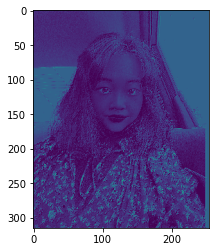

In [14]:
output = output.numpy()
output = output[0,...,0]
plt.imshow(output)

In [15]:
res = tf.nn.avg_pool(img, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

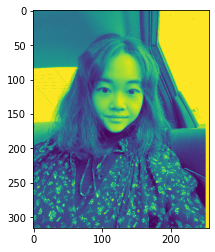

In [17]:
res = res.numpy()[0,...,0]
plt.imshow(res)

- Convolution layer의 Dense layer과의 결정적인 차이중 하나가 뉴런을 이전 계층의 이웃한 뉴런과만 연결함으로써 훈련시킬 매개변수의 개수를 급격하게 줄일 뿐만 아니라 '이미지 특징의 위치 정보까지 파악한다는 것'이다.
- 합성곱 계층은 또한 동일한 출력 커널에 연결된 모든 뉴런이 같은 가중치와 편향값을 갖는다는 사실 때문에 매개변수의 개수를 더 줄이는 것이 가능한 것이다.
    - 일반적으로 (k,k)의 크기의 정사각형 kernel을 이용하지만 가로의 길이와 세로의 길이가 충분히 다를 수 있다.
    - 합계에 활성화 함수를 적용하기 전에 patch에 의한 입력값을 선형으로 결합하게 되고, 이후에 응답 패치에 대한 뉴런의 응답이 표현이 가능해진다.
- 입력 행렬에서 입력 이미지에 적용하는 필터의 응답 맵은 필터가 타깃 특징에 반응하는 위치를 표현한 맵으로 볼 수 있다. 이 중간 결과를 특성 맵 (feature map)이라고 부르고 한 계층이 반환한 N개의 feature map의 stack은 특징 볼륨 (feature volume)이라고 한다.  


**지정해 주어야 하는 매개변수는 num_kernels = N, kernel_size = (k, k), strides = s, padding = p이다.**  
- padding = 'valid'로 설정을 하게 되면 이미지에 padding을 하지 않기 때문에 이미지의 크기가 줄어들게 될 것이다.
- 반면에 'same'으로 설정을 하게 되면 합성곱의 출력이 보폭(=strides)이 1인 입력과 동일한 높이와 너비를 갖게 된다.  


- CNN의 경우에는 필터를 훈련 가능하게 만들어야 하며 합성곱 계층은 결과를 활성화 함수에 전달하기 전에 **학습된 편향값**을 적용한다.
- keras로는 ```tf.keras.layers.Conv2D()```로 간단하게 표현이 가능한 합성곱 신경망의 하나의 계층을 모듈로 구현을 해보자.

In [70]:
class SimpleConvolutionLayer():
    def __init__(self, num_kernels = 32, kernel_size = (3,3), strides = (1,1), use_bias = True):
        super().__init__()
        #convolution layer에 사용하는 kernel의 수
        self.num_kernels = num_kernels
        #(kernel의 가로, kernel의 세로)
        self.kernel_size = kernel_size
        self.strides = strides
        self.use_bias = use_bias
    
    def build(self, input_shape):
        #이미지의 차원을 결정해줌 (gray scale, RGB등)
        num_input_channels = input_shape[-1]
        kernels_shape = [*self.kernel_size, num_input_channels, self.num_kernels] 
        #(k,k,N,D) N개의 가중치 행렬이 존재
        #이제 가중치(weight)값과 편향(bias)를 학습시키고 훈련시킬 수 있도록 해야 한다.
        
        #훈련 가능한 변수를 glorot 분포를 이용해서 초기화를 시켰다. (이는 원래 keras의 convolution layer도 동일하다.)
        glorot_uni = tf.initializers.GlorotUniform()
        
        self.kernels = tf.add_weight(
            shape = kernels_shape,
            initializer = glorot_uni,
            trainable = True
        )
        #편향값을 사용해서 학습을 시킬 것이라면
        if self.use_bias:
            self.bias = tf.add_bias(
                #편향은 각각의 계층마다 하나씩 존재(뉴런마다 존재하는 것이 아니라는 뜻임)
                shape = self.num_kernels,
                initializer = 'random_normal',
                trainable = True
            )
    def call(self, inputs):
        #self.strides의 앞에 * 를 붙인 이유는 이것이 하나의 정수가 아니라 행렬이기 떄문이다.
        #strides의 값은  batch로 나눈 입력의 각 차원에 대한 보폭을 나타내는 4개의 정수 리스트이다. [1,stride 가로, stride 세로, 1]으로 구성
        z = tf.nn.conv2d(inputs, self.kernels, strides = [1,*self.strides, 1], padding = 'VALID')
        if self.use_bias:
            z = z + self.bias
        #relu activation function에 넣은 값을 최종적으로 출력을 한다.
        return tf.nn.relu(z)

#### Pooling 계층
- 이 계층에는 훈련이 가능한 매개 변수가 존재하지 않는다.
- 각 뉴런은 자신의 window(수용 영역)의 값을 취하고 사전에 정의된 함수로 계산한 하나의 출력을 반환하도록 한다.
1. Max Pooling
    - pooling된 영역의 깊이마다 최댓값만을 반환
2. Average Pooling
    - pooling된 영역의 깊이마다 평균을 계산  
    
- pooling계층을 이용하는 이유는 데이터의 공간의 크기를 줄여서 네크워크에 필요한 매개변수의 개수를 줄여 계산 시간을 단축시키기 위함이다.

In [75]:
max_pooled_img = tf.nn.max_pool(
    img, 
    ksize = [1,10,10,1],
    strides = [1,2,2,1],
    padding = 'SAME'
)

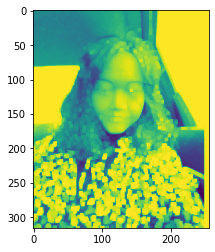

In [76]:
plt.imshow(max_pooled_img[0,...,0])

In [81]:
avg_pooled_img = tf.nn.avg_pool(
    img, 
    ksize = [1,5,5,1],
    strides = [1,5,5,1],
    padding = 'SAME'
)

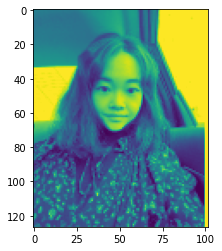

In [82]:
plt.imshow(avg_pooled_img[0,...,0])

In [84]:
avg_pooled_img.shape, max_pooled_img.shape 

(TensorShape([1, 127, 102, 3]), TensorShape([1, 316, 255, 3]))

**pooled 계층을 이용하면 kernel size와 동일한 stride의 크기를 사용하기 때문에 이미지의 크기가 줄어드는 것을 확인할 수 있다.**

- pooled 나 convolution이나 윈도우의 크기나 kernel의 크기, 그리고 stride의 크기 모두 **차원별로** 다르기 때문에 4차원으로 실제로는 구성이 되어 있어야 한다.
- 나중에 keras를 사용해서 padding layer을 구현하고자 할 때에는 훈련가능한 가중치가 없기 떄문에 실제로 pooling 연산과 그에 대응하는 계층 사이에 차이가 존재하지 않는다.


**신기하게도 kernel의 각 셀에서 중심부분으로 갈수록 주변부보다 가중치의 크기가 더 크게 저장이 되는 현상이 발생하는데, 이것은 인간의 눈의 시신경이 중심부와 연결이 더 많이 되어 있는 상황과 매우 유사하다.**
- CNN layer의 i번째 계층의 유효 수용 영역의 픽셀이 어떤 역할을 하는지와 무관하게 이 유효 수용 영역은 재귀적으로 계산이 된다.
- i번째 R(유효 수용영역) = (i-1)번째 R(유효 수용영역)+ (i번째 계층의 필터의 크기 - 1) * ((1부터 i-1번째 stride)의 합)

**이제 LeNet - 5를 모듈을 이용해서 만들어줄 예정이다.**
### LeNet-5
1. 두개의 합성곱 블록을 가지고 있는 모델이다.
- 각각의 블록은 합성곱 (kernel size = 5, stride = 1) 계층과 max-pool계층 (kernel size = 2, stride = 2)으로 이루어져 있다.
    - 첫번째 합성곱 층은 먼저 둘레를 p = 2로 0의 값으로 padding을 해준다.
    - 두번째 합성곱 층은 p = 0으로 설정함으로서 padding을 하지 않는다.
2. 마지막 layer은 Dense, 즉 완전 연결 신경망으로 설정을 해서 출력 계층의 크기를 10으로 정해서 softmax함수를 이용한다.
    - softmax함수는 N개의 값으로 구성된 벡터를 동일한 크기의 새로운 벡터를 확률분포로 정규화하여 반환한다.
    - 따라서 벡터를 정규화해 각 확률의 합이 1이 되도록 각 값을 0과 1사이의 값으로 만든다.

In [92]:
class LeNet5(tf.keras.Model):
#Model은 Layer과 동일한 API를 갖고 있지만 확장이 된 상태이다.
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters = 6, kernel_size = (5,5), padding = 'same', activation = 'relu')
        self.conv2 = tf.keras.layers.Conv2D(filters = 16, kernel_size = (5,5), padding = 'same', activation = 'relu')
        self.maxPool = tf.keras.layers.MaxPool2D(pool_size = (2,2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(64,activation = 'relu')
        self.dense2 = tf.keras.layers.Dense(32, activation = 'relu')
        self.dense3 = tf.keras.layers.Dense(num_classes, activation = 'softmax')
    
    def call(self, x):
        x = self.maxPool(self.conv1(x))
        x = self.maxPoool(self.conv2(x))
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x)))
        return x
        


In [93]:
model = LeNet5(3)

In [94]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [99]:
model.fit(train_val_dataset, epochs = 10)

  ...
    to  
  ['...']
Train for 69 steps
Epoch 1/10
69/69 [==============================] - 41s 589ms/step - loss: 310.7394 - accuracy: 0.3940
Epoch 2/10
69/69 [==============================] - 41s 590ms/step - loss: 264.7715 - accuracy: 0.4173
Epoch 3/10
69/69 [==============================] - 41s 591ms/step - loss: 149.0194 - accuracy: 0.4639
Epoch 4/10
69/69 [==============================] - 41s 589ms/step - loss: 105.9032 - accuracy: 0.4803
Epoch 5/10
69/69 [==============================] - 39s 569ms/step - loss: 130.9287 - accuracy: 0.4790
Epoch 6/10
69/69 [==============================] - 38s 548ms/step - loss: 147.1371 - accuracy: 0.4452
Epoch 7/10
69/69 [==============================] - 38s 553ms/step - loss: 92.6795 - accuracy: 0.5210
Epoch 8/10
69/69 [==============================] - 43s 622ms/step - loss: 91.6763 - accuracy: 0.5229
Epoch 9/10
69/69 [==============================] - 45s 651ms/step - loss: 45.4119 - accuracy: 0.6138
Epoch 10/10
69/69 [=============